# Assignment 3: Multi-Class Image Classification with CNNs

*Author: Brian Sterle*

*Date: April 15th, 2025*
___
### Installation
Before running the notebook, setup the data:

```bash
# in root dir of project
./fetch-data.sh
```

This fetches data from Kaggle via `curl` and unzips it to the `data/` directory

In [17]:
# Import required libraries
import os
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# verify torch installation
import torch
x = torch.rand(5, 3)
print(x)

# verify mps support for M-series chips
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408],
        [0.1332, 0.9346, 0.5936],
        [0.8694, 0.5677, 0.7411]])
tensor([1.], device='mps:0')


In [18]:
# Define directory paths for the dataset
data_dir = 'data'
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
test_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define image size and transformation pipelines

# choose an image size of 224x224
image_size = 224

# Transformation for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),     # Random flip for augmentation
    transforms.RandomRotation(15),           # Random rotation within ±15 degrees
    transforms.ToTensor(),                   # Convert image to PyTorch tensor and scales [0,255] to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Normalize based on ImageNet statistics
                         std=[0.229, 0.224, 0.225])
])

# Transformations for the validation and test sets (no augmentation, only resizing and normalization)
val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [19]:
# Load datasets using ImageFolder.
# Note: The ImageFolder directory structure should have subfolders for each class.
train_dataset_full = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Print basic info about the dataset
print("Classes:", train_dataset_full.classes)
print("Total images in the training folder:", len(train_dataset_full))
print("Total images in the test folder:", len(test_dataset))

# Create a stratified split (train/validation) for train_dataset_full.
# Our overall dataset split should be: 70% train, 15% val, 15% test.
# Since the test set is provided separately (15%), we split the training folder into:
#    Train: 70/85 ≈ 82.35% of train_dataset_full
#    Validation: 15/85 ≈ 17.65% of train_dataset_full

def stratified_split(dataset, train_ratio=70/85):
    """
    Splits the dataset into a train and validation set in a stratified manner.
    
    Parameters:
        dataset: the full ImageFolder dataset.
        train_ratio: proportion of samples (per class) to use for training.
    
    Returns:
        train_indices: list of indices for the training set.
        val_indices: list of indices for the validation set.
    """
    targets = np.array(dataset.targets)
    classes = np.unique(targets)
    train_idx = []
    val_idx = []
    
    for cls in classes:
        # Get indices for each class
        cls_idx = np.where(targets == cls)[0]
        n_samples = len(cls_idx)
        n_train = int(np.floor(train_ratio * n_samples))
        # Shuffle indices for randomness
        np.random.shuffle(cls_idx)
        # Assign indices for training and validation splits
        train_idx.extend(cls_idx[:n_train])
        val_idx.extend(cls_idx[n_train:])
        
    return train_idx, val_idx

# Compute stratified indices using the ratio derived from a 70-15-15 split overall.
train_idx, val_idx = stratified_split(train_dataset_full, train_ratio=70/85)
print(f"Total training samples after split: {len(train_idx)}")
print(f"Total validation samples after split: {len(val_idx)}")


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Total images in the training folder: 14034
Total images in the test folder: 3000
Total training samples after split: 11554
Total validation samples after split: 2480


In [20]:
# Create the Subset datasets for training and validation
train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(train_dataset_full, val_idx)

# Create DataLoaders for each set
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("DataLoaders ready:")
print("  Training batches:", len(train_loader))
print("  Validation batches:", len(val_loader))
print("  Test batches:", len(test_loader))

# Create DataLoaders for each set
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("DataLoaders ready:")
print("  Training batches:", len(train_loader))
print("  Validation batches:", len(val_loader))
print("  Test batches:", len(test_loader))


DataLoaders ready:
  Training batches: 362
  Validation batches: 78
  Test batches: 94
DataLoaders ready:
  Training batches: 362
  Validation batches: 78
  Test batches: 94


Training set samples per class:
{'buildings': 1804, 'forest': 1870, 'glacier': 1979, 'mountain': 2068, 'sea': 1872, 'street': 1961}

Validation set samples per class:
{'buildings': 387, 'forest': 401, 'glacier': 425, 'mountain': 444, 'sea': 402, 'street': 421}

Test set samples per class:
{'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


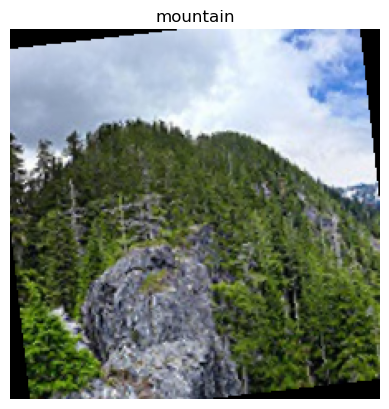

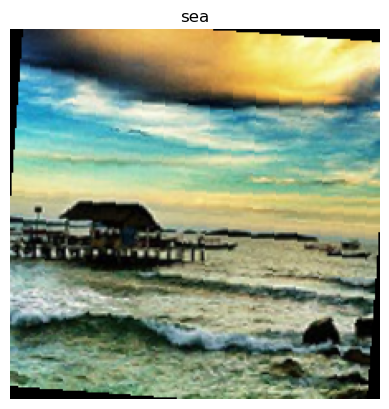

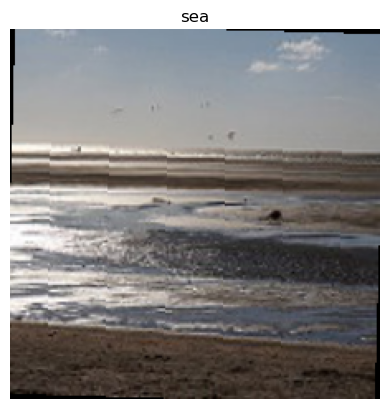

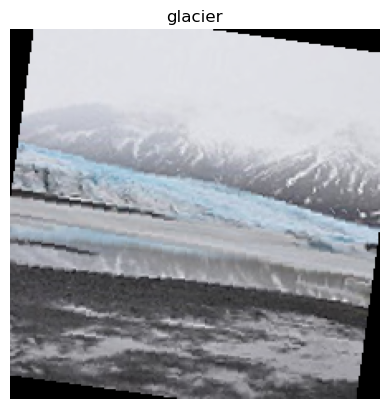

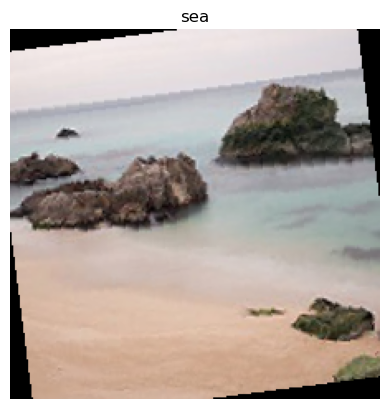

In [21]:
# Simple data exploration: Counting the number of samples per class in each subset.

def count_labels(subset, dataset_full):
    """
    Counts samples per class for a given subset.
    
    Parameters:
        subset: a Subset object of the full dataset.
        dataset_full: the full ImageFolder dataset (to retrieve class names and targets).
        
    Returns:
        A dictionary mapping class names to sample counts.
    """
    counts = {class_name: 0 for class_name in dataset_full.classes}
    for idx in subset.indices:
        label = dataset_full.targets[idx]
        class_name = dataset_full.classes[label]
        counts[class_name] += 1
    return counts

train_counts = count_labels(train_dataset, train_dataset_full)
val_counts = count_labels(val_dataset, train_dataset_full)

# Count labels in test dataset manually (ImageFolder object has `imgs` attribute)
test_counts = {class_name: 0 for class_name in test_dataset.classes}
for _, label in test_dataset.imgs:
    class_name = test_dataset.classes[label]
    test_counts[class_name] += 1

print("Training set samples per class:")
print(train_counts)
print("\nValidation set samples per class:")
print(val_counts)
print("\nTest set samples per class:")
print(test_counts)

# Visualize a few sample images from the training set

def imshow(img, title=None):
    """Display an image after unnormalizing it."""
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize based on the ImageNet values
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display 5 sample images from the batch
for i in range(5):
    label_name = train_dataset_full.classes[labels[i]]
    imshow(images[i], title=label_name)
